In [8]:
import os
import numpy as np
import pandas as pd
import cv2

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

In [9]:
#Define absolute paths to the 6 subdirectories containing the x-ray images
basepath = os.getcwd() + "\\chest_xray\\"

testnormal_path = basepath + "test\\NORMAL\\"
trainnormal_path = basepath + "train\\NORMAL\\"
valnormal_path = basepath + "val\\NORMAL\\"

testpneumonia_path = basepath + "test\\PNEUMONIA\\"
trainpneumonia_path = basepath + "train\\PNEUMONIA\\"
valpneumonia_path = basepath + "val\\PNEUMONIA\\"

pathlist = [testnormal_path, trainnormal_path, valnormal_path, testpneumonia_path, trainpneumonia_path, valpneumonia_path]

In [10]:
#Get the dataframe holding compressed, black and white image.
def get_df(path, dtype, label, m, n):
    imgs = list()
    dirents = os.listdir(path)
    for dirent in dirents[m:n]:
        img_path = path + "\\" + dirent
        imgs.append((get_img(img_path, resized=True, bnw=True), label))
    df = pd.DataFrame(imgs, columns=['image', 'label'])
    return df

In [11]:
#Return the image matrix as read by opencv python library, with optional compression and conversion to black and white.
def get_img(path, resized, bnw):
    img = cv2.imread(path)
    if(resized==False and bnw==False):
        return img
    if(resized==True and bnw==False):
        return cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)
    if(resized==False and bnw==True):
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (128, 128), interpolation=cv2.INTER_AREA).reshape(1, -1)

### Exploration of Dataset
The dataset contains a total of 5856 images across the test, training, and validation sets. All images have labels. 
Across a sample size of 100 jpeg images in each of the 6 provided directories, the images have an average size of 1126 x 1495 pixels with 3 channels (R, G, B).

As is seen from the histograms below of a randomly selected image in the dataset (compressed to 128x128), the distribution of color intensity in the image is extremely similar, so during feature extraction we will use only black and white versions of the images to reduce complexity.

In [12]:
heights = []
widths = []
channels = []
num_images = 0
for path in pathlist:
    dirents = os.listdir(path)
    num_images += len(dirents)
    for dirent in dirents[0:100]:
        img_path = path + "\\" + dirent
        img = get_img(img_path, resized=False, bnw=False)
        heights.append(img.shape[0]), widths.append(img.shape[1]), channels.append(img.shape[2])
print(f'Total number of images: {num_images:d}')
print(f'Avg size of images (pixels x pixels x channels): {np.mean(heights):.0f} x {np.mean(widths):.0f} x {np.mean(channels):.0f}')

Total number of images: 5856
Avg size of images (pixels x pixels x channels): 1126 x 1495 x 3


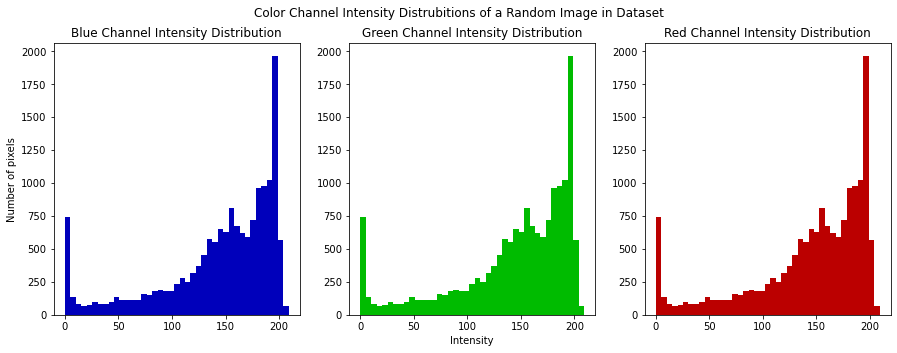

In [13]:
img_path = pathlist[np.random.randint(0, 6)]
dirents = os.listdir(img_path)
img_path = img_path + dirents[np.random.randint(0, len(dirents))]
img = get_img(img_path, resized=True, bnw=False)
blue,green,red = cv2.split(img)
blue = np.ndarray.flatten(blue)
green = np.ndarray.flatten(green)
red = np.ndarray.flatten(red)

fig, axs = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Color Channel Intensity Distrubitions of a Random Image in Dataset')
axs[0].hist(x=blue, bins='auto', color='#0000bb')
axs[0].set_ylabel('Number of pixels')
axs[0].set_title('Blue Channel Intensity Distribution')
axs[1].hist(x=green, bins='auto', color='#00bb00')
axs[1].set_title('Green Channel Intensity Distribution')
axs[1].set_xlabel('Intensity')
axs[2].hist(x=red, bins='auto', color='#bb0000')
axs[2].set_title('Red Channel Intensity Distribution')
plt.show()

### Pre-processing & Feature Extraction

Using the OpenCV python library, we will convert 500 of the jpeg images from each the training and test data into compressed, black & white, 128x128 images. The image dataset is already preprocessed and divided into test, training, and validation categories, and all images are labeled. 

In [14]:
df_train = get_df(trainnormal_path, 'train', 'NORMAL', 0, 500)
df_train = df_train.append(get_df(trainpneumonia_path, 'train', 'PNEUMONIA', 0, 500))

X_train = []
y_train = df_train.label
for img in df_train.image.values:
    X_train.append(img[0])
X_train = np.asarray(X_train)

In [15]:
df_test = get_df(testnormal_path, 'test', 'NORMAL', 0, 234)
df_test = df_test.append(get_df(testpneumonia_path, 'test', 'PNEUMONIA', 0, 390))

X_test = []
y_test = df_test.label
for img in df_test.image.values:
    X_test.append(img[0])
X_test = np.asarray(X_test)

In [16]:
df_val = get_df(trainnormal_path, 'train', 'NORMAL', 500, 750)
df_val = df_val.append(get_df(trainpneumonia_path, 'train', 'PNEUMONIA', 500, 750))
valranges = [(0, 60), (60, 120), (120, 180), (240, 300)]
df_val = df_val.sample(frac=1).reset_index(drop=True)
val_list = []
for rng in valranges:
    X_val = []
    y_val = (df_val[rng[0]:rng[1]].label)
    for img in df_val[rng[0]:rng[1]].image.values:
        X_val.append(img[0])
    val_list.append((np.asarray(X_val), y_val))

### Processing of dataset
1. KNN
    - Using sklearn's KNeighborsClassifier model
    - Use k values 1, 3, 5, 10, 20, 50, 100
    - Calculate predictions on validation data and select the optimal hyperparameter k
    - Run predictions on the test data with the optimal hyperparameter k
2. SVC with a linear kernel
    - Using sklearn's SVC model
    - Use regularization parameter "c" values 0.025, 0.05, 0.1, 0.5, 1, 2, 5, 10, 100
    - Calculate predictions on validation data and select the optimal hyperparameter c
    - Run predictions on the test data with the optimal hyperparameter c
3. GNB
    - Using sklearn's GaussianNB model
    - Calculate predictions on the test data

In [17]:
kvals = [1, 3, 5, 10, 20, 50, 100]
val_acc_list = []
test_acc_list = []
for k in kvals:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    count = 1
    acc_list_tup_specific = []
    for tup in val_list:
        val_predictions = model.predict(tup[0])
        val_acc = metrics.accuracy_score(tup[1], val_predictions)
        acc_list_tup_specific.append(val_acc)
        count = count + 1
    val_acc_list.append(np.mean(acc_list_tup_specific))
optimal_k = kvals[np.argmax(val_acc_list)]
model = KNeighborsClassifier(n_neighbors=optimal_k)
model.fit(X_train, y_train)
test_predictions = model.predict(X_test)
df_test['k=' + str(optimal_k)] = test_predictions
test_acc = metrics.accuracy_score(y_test, test_predictions)
test_acc_list.append(('k=' + str(optimal_k), test_acc))

In [18]:
cvals = [0.025, 0.05, 0.1, 0.5, 1, 2, 5, 10, 100]
val_acc_list = []
for c in cvals:
    model = SVC(kernel="linear", C=c)
    model.fit(X_train, y_train)
    acc_list_tup_specific = []
    for tup in val_list:
        val_predictions = model.predict(tup[0])
        val_acc = metrics.accuracy_score(tup[1], val_predictions)
        acc_list_tup_specific.append(val_acc)
        count = count + 1
    val_acc_list.append(np.mean(acc_list_tup_specific))
optimal_c = kvals[np.argmax(val_acc_list)]
model = SVC(kernel="linear", C=optimal_c)
model.fit(X_train, y_train)
test_predictions = model.predict(X_test)
df_test['c=' + str(optimal_c)] = test_predictions
test_acc = metrics.accuracy_score(y_test, test_predictions)
test_acc_list.append(('c=' + str(optimal_c), test_acc))

In [19]:
model = GaussianNB()
model.fit(X_train, y_train)
test_predictions = model.predict(X_test)
df_test['GNB'] = test_predictions
test_acc = metrics.accuracy_score(y_test, test_predictions)
test_acc_list.append(('GNB', test_acc))

### Comparative Analysis


In [20]:
temp = df_test.loc[df_test['k=' + str(optimal_k)] == "PNEUMONIA"]
KNN_TP = len(temp.loc[temp['label'] == "PNEUMONIA"])
KNN_FP = len(temp.loc[temp['label'] == "NORMAL"])
temp = df_test.loc[df_test['k=' + str(optimal_k)] == "NORMAL"]
KNN_TN = len(temp.loc[temp['label'] == "NORMAL"])
KNN_FN = len(temp.loc[temp['label'] == "PNEUMONIA"])

In [21]:
temp = df_test.loc[df_test['c=' + str(optimal_c)] == "PNEUMONIA"]
SVM_TP = len(temp.loc[temp['label'] == "PNEUMONIA"])
SVM_FP = len(temp.loc[temp['label'] == "NORMAL"])
temp = df_test.loc[df_test['c=' + str(optimal_c)] == "NORMAL"]
SVM_TN = len(temp.loc[temp['label'] == "NORMAL"])
SVM_FN = len(temp.loc[temp['label'] == "PNEUMONIA"])

In [22]:
temp = df_test.loc[df_test['GNB'] == "PNEUMONIA"]
GNB_TP = len(temp.loc[temp['label'] == "PNEUMONIA"])
GNB_FP = len(temp.loc[temp['label'] == "NORMAL"])
temp = df_test.loc[df_test['GNB'] == "NORMAL"]
GNB_TN = len(temp.loc[temp['label'] == "NORMAL"])
GNB_FN = len(temp.loc[temp['label'] == "PNEUMONIA"])

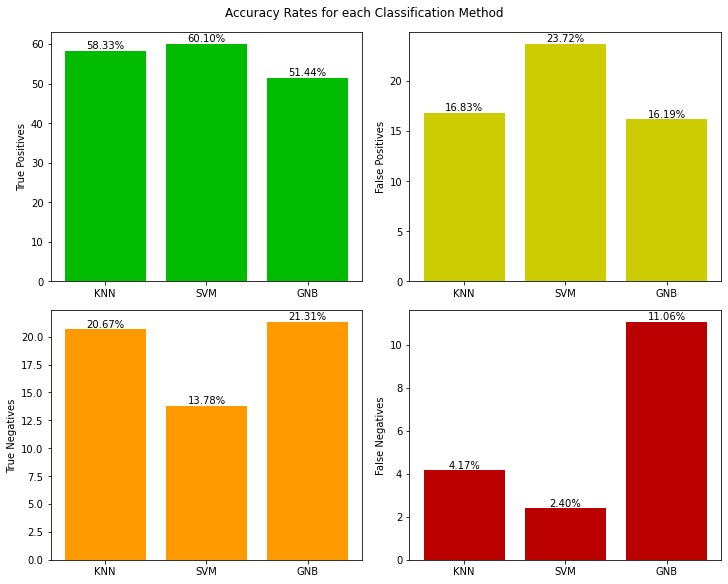

Number of test samples: 624
KNN Accuracy: 79.01%
SVM Accuracy: 73.88%
GNB Accuracy: 72.76%


In [23]:
num_samples = df_test.shape[0]
def autolabel(rects, m, n):
    for rect in rects:
        height = rect.get_height()
        axs[m][n].text(rect.get_x() + rect.get_width()/2., 1*height, '%.2f' % float(height) + str("%"), ha='center', va='bottom')
        
fig, axs = plt.subplots(2, 2, figsize=(10,8), constrained_layout=True)
fig.suptitle('Accuracy Rates for each Classification Method')
x = ['KNN', 'SVM', 'GNB']
x_pos = [i for i, _ in enumerate(x)]

y = [KNN_TP / num_samples * 100, SVM_TP / num_samples * 100, GNB_TP / num_samples * 100]
rects0 = axs[0][0].bar(x_pos, y, color="#00bb00")
axs[0][0].set_ylabel("True Positives")
y = [KNN_FP / num_samples * 100, SVM_FP / num_samples * 100, GNB_FP / num_samples * 100]
rects1 = axs[0][1].bar(x_pos, y, color="#cccc00")
axs[0][1].set_ylabel("False Positives")
y = [KNN_TN / num_samples * 100, SVM_TN / num_samples * 100, GNB_TN / num_samples * 100]
rects2 = axs[1][0].bar(x_pos, y, color="#ff9900")
axs[1][0].set_ylabel("True Negatives")
y = [KNN_FN / num_samples * 100, SVM_FN / num_samples * 100, GNB_FN / num_samples * 100]
rects3 = axs[1][1].bar(x_pos, y, color="#bb0000")
axs[1][1].set_ylabel("False Negatives")

plt.setp(axs, xticks=[0, 1, 2], xticklabels=x)
autolabel(rects0, 0, 0)
autolabel(rects1, 0, 1)
autolabel(rects2, 1, 0)
autolabel(rects3, 1, 1)

plt.show()

print(f'Number of test samples: {num_samples}')
print(f'KNN Accuracy: {(KNN_TP + KNN_TN) * 100 / num_samples:.2f}%')
print(f'SVM Accuracy: {(SVM_TP + SVM_TN) * 100 / num_samples:.2f}%')
print(f'GNB Accuracy: {(GNB_TP + GNB_TN) * 100 / num_samples:.2f}%')

The SVM classifier has the highest True Positive rate and lowest False Negative rate of any of the classifiers on this dataset, although the KNN classifier has a similar True Positive and False Negative rates with fewer False Positives. Therefore, optimally, the KNN classifier should be used for production out of these three classifiers. 

### Ethical Issues
There are a few ethical issues that could potentially arise with this task. The first issue is that lungs infected with diseases other than pneumonia could potentially be classified as pneumonia positive, however, such an issue is outside the scope of this task. Another issue that could arise depends on how the x-ray imaging data is collected. The description of the dataset suggests that the x-ray images were taken from pediatric patients as part of routine clinical care. There is evidence which suggests that exposing children to unnecessary radiation can have adverse side effects. In addition, it is not mentioned whether the parents of the patients consented to the release of their child's medical data for research purposes such as this. Future datasets on medical data should make sure to include that the patient or their legal guardian consented to the release of data.

### Bibliography
Mooney, Paul. “Chest X-Ray Images (Pneumonia).” Kaggle, Google, LLC, 24 Mar. 2018, www.kaggle.com/paultimothymooney/chest-xray-pneumonia.

N/A, N/A. “OpenCV-Python Tutorials.” OpenCV, Willow Garage, 2020, www.docs.opencv.org/master/d6/d00/tutorial_py_root.html.

Varoquaux, Gaël, and Andreas Müller. “Classifier Comparison.” Edited by Jaques Grobler, Scikit-Learn, Scikit-Learn Developers, 2020, www.scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html. 